# 1. Packeges and dependencies

In [2]:
# Liberies
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm

# 2. Data processing

In [3]:
# Mutation counts of patients as an input to neural net
muts = pd.read_csv('../data/mut_count_summery.csv')  
muts.head()

,Chromosome,EX5261,EX5342,EX5347,EX5348,EX5349,EX5364,EX5365,EX5428,EX5429,...,EX5530,EX5531,EX5533,EX5539,EX5540,EX5541,EX5542,EX5544,EX5545,EX5555
0,chr1,11664,12902,13262,13177,13061,12320,12924,15688,14857,...,3493,3459,3661,3554,3569,3547,3387,3365,3550,3432
1,chr2,9156,9377,9419,9905,10536,9247,9848,11934,11323,...,2462,2507,2372,2425,2508,2435,2227,2518,2540,2402
2,chr3,7016,6932,7360,7314,7703,7160,7144,8790,7617,...,2039,2109,2141,2169,2184,2083,2102,1988,2107,2206
3,chr4,5267,5285,5472,5733,5821,5290,5824,7064,6577,...,1394,1475,1453,1437,1465,1484,1489,1408,1499,1435
4,chr5,5556,5699,5741,6191,6261,5762,6002,7124,6408,...,1541,1541,1552,1600,1583,1573,1542,1565,1542,1556


In [4]:
# Binary labels of each patient (mild/Severe)
labels = pd.read_csv('../data/labels.csv')  
labels.head()

,ID,Group
0,5261,Severe
1,5342,Severe
2,5347,Severe
3,5348,Severe
4,5349,mild


In [5]:
# Making a dictionary with Id as key and label as the value
labels_dic = {'EX'+str(labels['ID'][i]):labels['Group'][i] for i in range(len(labels))}
#labels_dic

### The inputs to the neural network are 25 digit long tensors representing the number of mutations of each patient. The values are very big so there should be normalized. There are two ways to normalize the values eaither globally or individually. 
### We defined two set of functions to apply each of thoses methods.


In [6]:
# ====== Functions ====== #

# Global normalizing
def norm_glob(tensor, df):
    tmp = df.max().tolist()
    ts = tensor/max(tmp[1:])
    return(ts)

# Individual normalizing
def norm_ind(tensor):
    ts = tensor/tensor.max()
    return(ts)

# Changes Severe -> 1 , mild -> 0
def convert_type(condition):
    if condition == 'Severe':
        return(1)
    else:
        return(0)

In [7]:
# ====== inputs and labels ====== #

x1 = [] # muts_norm_glob
x2 = [] # muts_norm_ind
y = [] # labels (Severe:1, mild:0) 

# making the two sets of inputs and their labels
for patient in labels_dic.keys():
    ts = torch.FloatTensor(muts[patient])
    x1.append(norm_glob(ts, muts).tolist())
    x2.append(norm_ind(ts).tolist())
    y.append(convert_type(labels_dic[patient]))

x1 = torch.FloatTensor(x1)
x2 = torch.FloatTensor(x2)
y = torch.FloatTensor(y)


# 3. Model

In [95]:
from torch import nn, optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

RANDOM_SEED = 36
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [116]:
# ====== model ====== #

class Net(nn.Module):
  def __init__(self, n_features):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(n_features, 12)
    self.fc2 = nn.Linear(12, 5)
    #self.fc3 = nn.Linear(15, 10)
    self.fc3 = nn.Linear(5, 1)
    
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    #x = F.relu(self.fc3(x))
    return torch.sigmoid(self.fc3(x))


# 4. Training

In [118]:
X_train, X_test, y_train, y_test = train_test_split(x2, y, test_size=0.2, random_state=RANDOM_SEED)

In [127]:
net = Net(X_train.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)

def round_tensor(t, decimal_places=4):
  return round(t.item(), decimal_places)

for epoch in range(2000):
    y_pred = net(X_train)
    y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, y_train)
    if epoch % 150 == 0:
      train_acc = calculate_accuracy(y_train, y_pred)
      y_test_pred = net(X_test)
      y_test_pred = torch.squeeze(y_test_pred)
      test_loss = criterion(y_test_pred, y_test)
      test_acc = calculate_accuracy(y_test, y_test_pred)
      print(
f'''epoch {epoch}
Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
Test  set - loss: {round_tensor(test_loss)}, accuracy: {round_tensor(test_acc)}
''')
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

epoch 0
Train set - loss: 0.6928, accuracy: 0.5185
Test  set - loss: 0.6865, accuracy: 0.5714

epoch 150
Train set - loss: 0.6748, accuracy: 0.5926
Test  set - loss: 0.6725, accuracy: 0.5714

epoch 300
Train set - loss: 0.6304, accuracy: 0.5926
Test  set - loss: 0.6371, accuracy: 0.5714

epoch 450
Train set - loss: 0.5727, accuracy: 0.5926
Test  set - loss: 0.5754, accuracy: 0.5714

epoch 600
Train set - loss: 0.4664, accuracy: 0.8519
Test  set - loss: 0.4486, accuracy: 0.8571

epoch 750
Train set - loss: 0.3729, accuracy: 0.8519
Test  set - loss: 0.3501, accuracy: 1.0

epoch 900
Train set - loss: 0.2989, accuracy: 0.8889
Test  set - loss: 0.2975, accuracy: 1.0

epoch 1050
Train set - loss: 0.2369, accuracy: 0.9259
Test  set - loss: 0.2811, accuracy: 0.8571

epoch 1200
Train set - loss: 0.1881, accuracy: 0.963
Test  set - loss: 0.2868, accuracy: 0.8571

epoch 1350
Train set - loss: 0.1498, accuracy: 0.963
Test  set - loss: 0.306, accuracy: 0.8571

epoch 1500
Train set - loss: 0.1194, a

In [124]:
# saving the model
MODEL_PATH = 'model3.pth'
torch.save(net, MODEL_PATH)

# 5. Evaluation

In [121]:
classes = ['mild', 'Severe']
y_pred = net(X_test).cpu()
y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test
print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

        mild       0.80      1.00      0.89         4
      Severe       1.00      0.67      0.80         3

    accuracy                           0.86         7
   macro avg       0.90      0.83      0.84         7
weighted avg       0.89      0.86      0.85         7



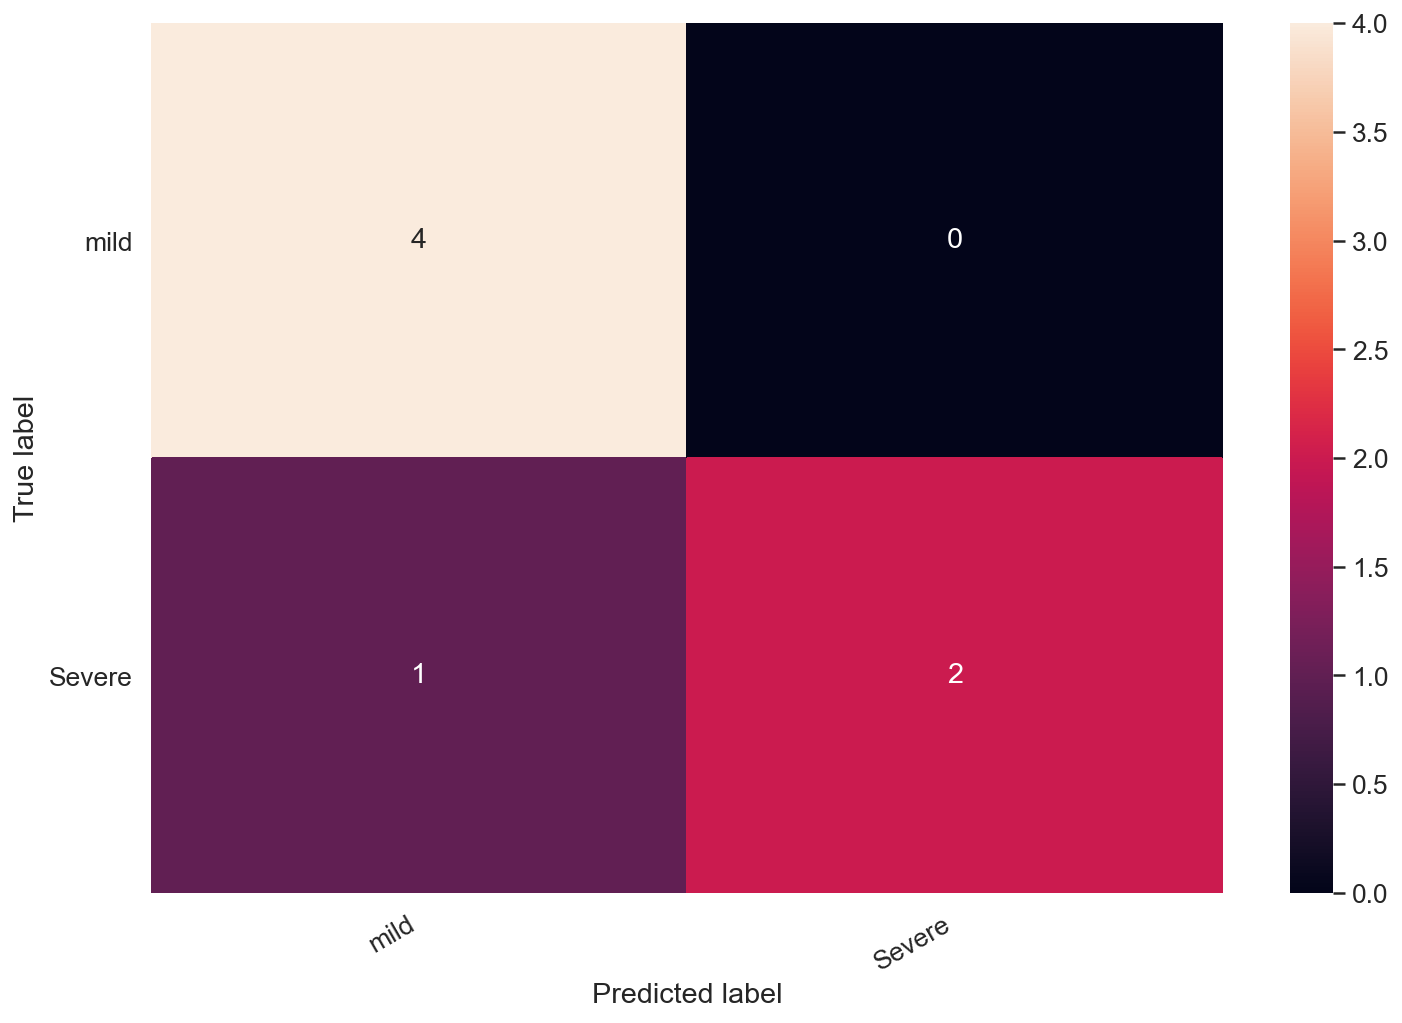

In [126]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE =\
["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

# 6. Making perdictions

In [128]:
def predict_type():
  t = torch.as_tensor([mut_counts]).float()
  output = net(t)
  return output.ge(0.5).item()

In [ ]:
https://curiousily.com/posts/build-your-first-neural-network-with-pytorch/